In [1]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
from zipfile import ZipFile
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder , StandardScaler
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import missingno as msno 
from pycaret.classification import *
# if not os.path.exists('./spaceship-titanic.zip'):
#     !kaggle competitions download -c spaceship-titanic
#     with ZipFile('./spaceship-titanic.zip') as z: z.extractall()
#     os.remove('./spaceship-titanic.zip')

## 함수 호출 및 라이브러리 호출

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows',    100)
pd.set_option('display.min_rows',    100)

In [3]:
def get_original_df():
    train, test, submission = pd.read_csv('./train.csv'),pd.read_csv('./test.csv') ,pd.read_csv('./sample_submission.csv')
    return train, test, submission

def df_null_check(df :pd.DataFrame , num:int):
    answer = {}

    for i in range(len(df)):
        if num== df.iloc[i,:].isnull().sum():
            answer[i] = df.iloc[i,:].isnull().sum()
    
    return list(answer.keys())

def label_encoding(df:pd.DataFrame, target:str):
    encoder = LabelEncoder()

    # 'HomePlanet' 열을 인코딩
    df[target] = encoder.fit_transform(df[target])

def continueous_encoding(df:pd.DataFrame, target:str):
    df[target] = df[target].apply(lambda x: 0 if x==0 else(1 if x <=1000 else (2 if x >1000 else 3)))

def df_cabin(df:pd.DataFrame, target = 'Cabin'):
    target_list = [target+'_deck',target+'_num',target+'_side']
    df[target_list] = df[target].str.split('/',expand=True)
    label_encoding(df, target_list[0])
    label_encoding(df, target_list[2])


## 데이터 불러오기 및 EDA

In [4]:
train, test, submission = get_original_df()

In [5]:
train.head().style.background_gradient(cmap='Blues')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,Willy Santantines,True


In [6]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


<Axes: >

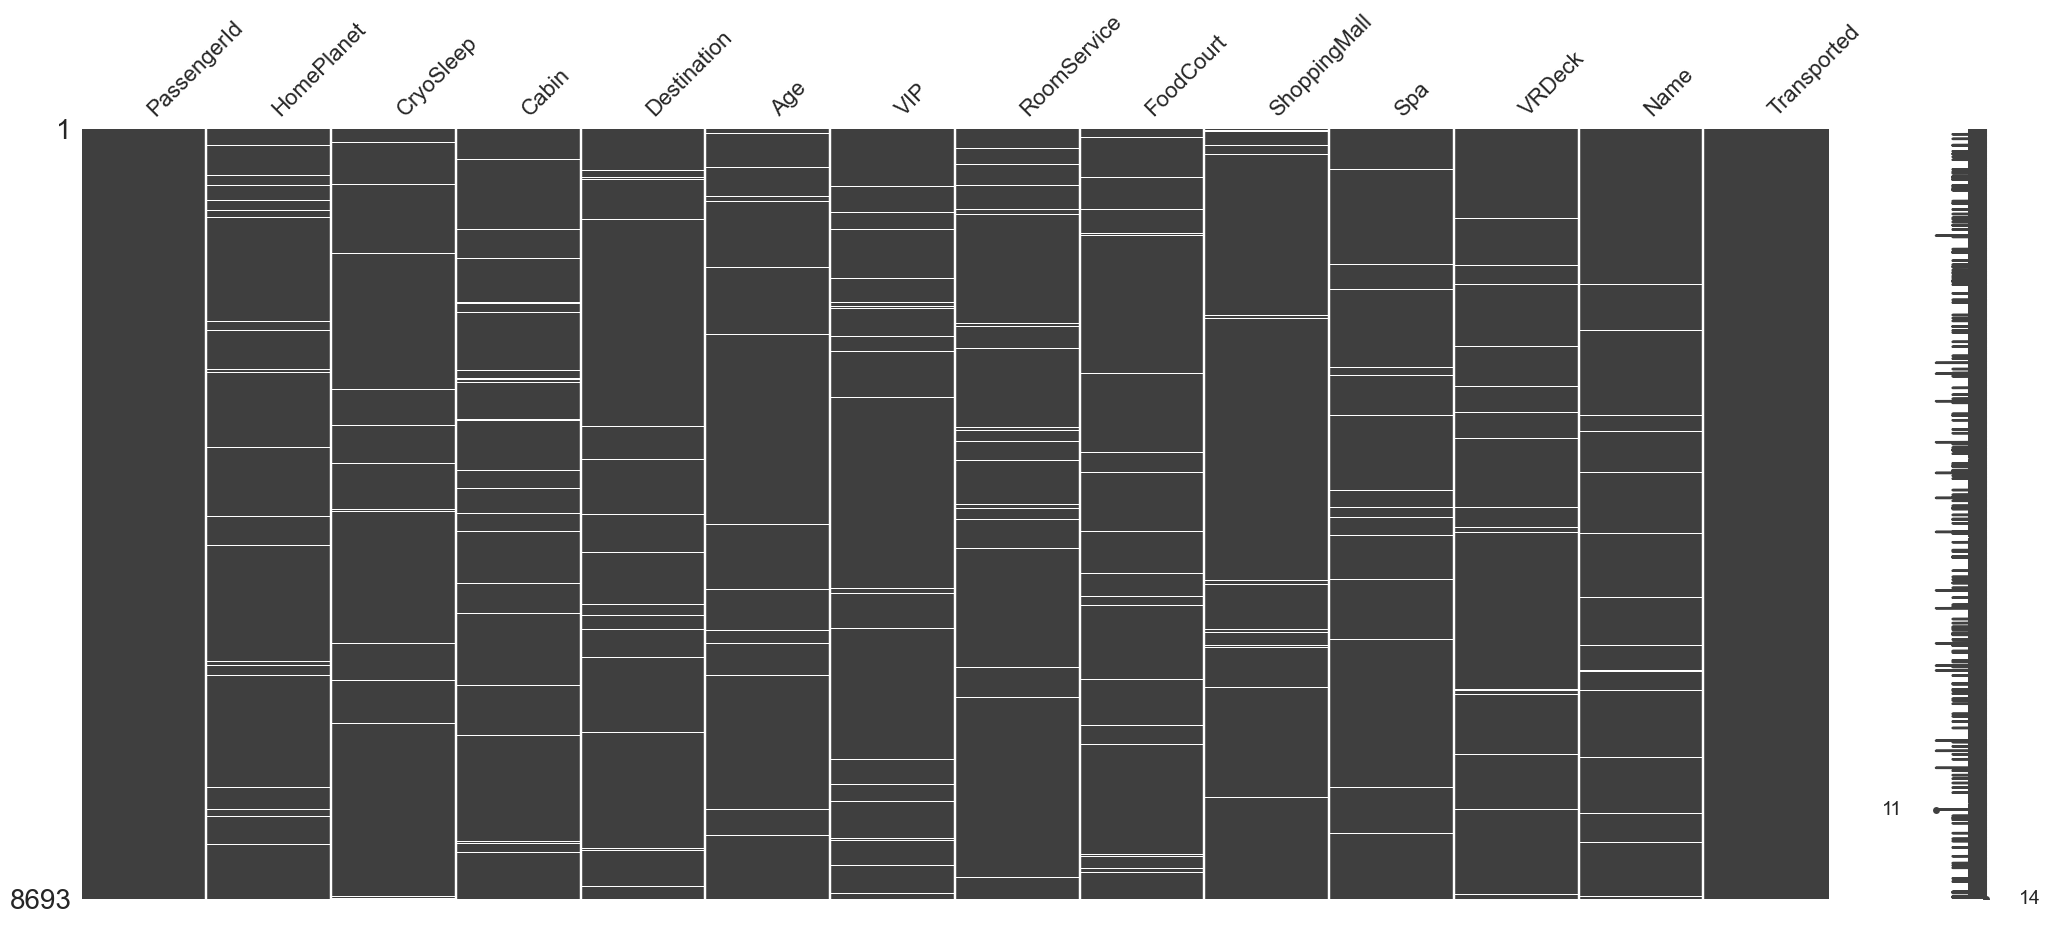

In [9]:
msno.matrix(train)
# 결측치 확인하기 

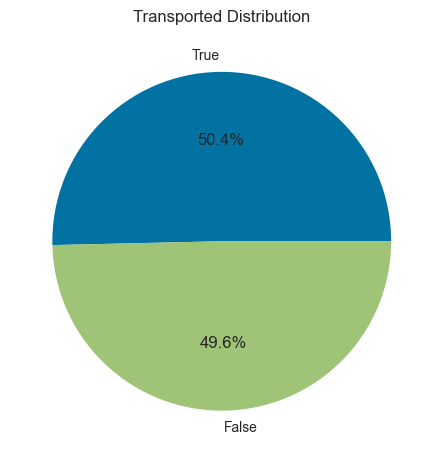

In [10]:
# Count the values in the 'Transported' column
transported_counts = train['Transported'].value_counts()

# Create a pie chart
plt.pie(transported_counts, labels=transported_counts.index, autopct='%1.1f%%')
plt.title('Transported Distribution')

# Display the pie chart
plt.show()


### 전체적인 전처리
#### 데이터를 살펴본 결과
* cryosleep이 True이면무조건 roomservice, foodcourt, shoppingmall, spa, vrdeck이 0이여야 한다는 것을 확인 그러므로 cryosleep== True 이면 이 것들을 0으로 채워주기     
* Age가 12 이하 이면 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 의 값들이 0 이라는 것을 확인 
* VIP, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 의 값들이 1 이상이면 cryosleep이 무조건 False
* Homeplanet이 earth 이면 False 하기

In [11]:
df_all = pd.concat([train, test])
df_all = df_all.reset_index(drop=True )
df_all['Passenger_member'] = df_all['PassengerId'].apply(lambda x: int(x[0]))
df_all['group'] = df_all['PassengerId'].str.split('_').str[1]
df_all.loc[df_all.query('Age <= 12 | CryoSleep == True').index, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]=0
df_all['Age'] = df_all['Age'].apply(lambda x: 0 if x==0 else (1 if x<=12 else (2 if x<=17 else (3 if x<=24 else (4 if x<=30 else(5 if x<= 39 else (6 if x<=48 else (7 if x<=58 else (8 if x >58 else x)))))))))
df_all.loc[df_all.query('HomePlanet == "Earth"').index , 'VIP'] = False
df_all['Cabin_deck'] = df_all['Cabin'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else x)
df_all['Cabin_num'] = df_all['Cabin'].apply(lambda x: int(x.split('/')[1]) if isinstance(x, str) else x)
df_all['Cabin_num'] = df_all['Cabin_num'].apply(lambda x:0 if x <300 else(1 if x<600 else (2 if x< 1150  else (3 if x<1500 else (4 if x>=1500 else x)))))
df_all['Cabin_side'] = df_all['Cabin'].apply(lambda x: x.split('/')[2] if isinstance(x, str) else x)
df_all['CryoSleep'] = df_all['CryoSleep'].astype(float)
df_all['VIP'] = df_all['VIP'].apply(lambda x: 1 if x is True else (0 if x is False else x))
df_all= df_all.drop(columns= ['PassengerId','Name','Cabin'])
df_all['Transported'] = df_all['Transported'].astype(float)
label_encoding(df_all, 'group')
before_all_nan = df_all.isnull().sum()

In [12]:
expenses = {}
for i in range(len(df_all)):
    expenses[i] = df_all.loc[i,['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum()

In [13]:
expenses_not_0 = [key for key, value in expenses.items() if value > 0]
df_all.loc[df_all.iloc[expenses_not_0, :].index, 'CryoSleep'] = False

In [14]:
df =df_all.drop(columns='Transported')
df_notnull= df[df.notnull().all(axis=1)]

In [15]:
expenses_0 = [key for key, value in expenses.items() if value == 0]
df_all.loc[expenses_0, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]=0
expenses_between_1000 = [key for key, value in expenses.items() if 0<value <= 1000 ]
expenses_over_1000 = [key for key, value in expenses.items() if value > 1000 ]
expenses_between_1500 = [key for key, value in expenses.items() if 0<value <= 1500 ]
expenses_between_2000 = [key for key, value in expenses.items() if 0<value <= 2000 ]
expenses_between_2500 = [key for key, value in expenses.items() if 0<value <= 2500 ]
expenses_over_1500 = [key for key, value in expenses.items() if value > 1500 ]
expenses_over_2000 = [key for key, value in expenses.items() if value > 2000 ]
expenses_over_2500 = [key for key, value in expenses.items() if value > 2500 ]
expenses_3000 = [key for key, value in expenses.items() if value > 3000 ]
expenses_5000 = [key for key, value in expenses.items() if value > 5000 ]
expense = [0 if value == 0 else (1 if value <= 1500 else 2) for key, value in expenses.items()]

# df_all.loc[expenses_1500,:]

In [16]:
df_all['expenses']= expense
df_over_1500 = df_all.loc[expenses_over_1500,:]
df_under_1500= df_all.drop(index=df.loc[expenses_over_1500,:].index)
df_over_1500['HomePlanet']  = df_over_1500['HomePlanet'].fillna('Europa')
df_under_1500['HomePlanet']  = df_under_1500['HomePlanet'].fillna('Earth')
df_all = pd.concat([df_over_1500, df_under_1500])
df_all = df_all.sort_index()

In [17]:
df_all_g_b = df_all.query('((expenses == 0) & (Cabin_deck == "G")) | ((expenses == 0) & (Cabin_deck == "B")) ')
df_all_not_g_b = df_all.drop(index=df_all_g_b.index)

df_all_g_b.loc[:,'CryoSleep'] = df_all_g_b.loc[:,'CryoSleep'].fillna(1)
df_all_not_g_b.loc[:,'CryoSleep'] = df_all_not_g_b.loc[:,'CryoSleep'].fillna(0)
df_all= pd.concat([df_all_not_g_b, df_all_g_b])
df_all=  df_all.sort_index()

In [18]:
df_all.loc[:,'Destination'] = df_all.loc[:,'Destination'].fillna('TRAPPIST-1e')
df_all.loc[:,'VIP'] = df_all.loc[:,'VIP'].fillna(0)

In [19]:
expenses_list  = [expenses_0, expenses_between_1000, expenses_between_1500, expenses_over_1000, expenses_over_1500,expenses_not_0, expenses_3000,expenses_5000,expenses_between_2000,expenses_between_2500]
expenses_list_name  = ['expenses_0', 'expenses_between_1000', 'expenses_between_1500', 'expenses_over_1000', 'expenses_over_1500','expenses_not_0', 'expenses_3000','expenses_5000','expenses_over_2000','expenses_between_2500']
for price ,name in zip(expenses_list,expenses_list_name):
    print(name)
    print(df_all.loc[price,:].Age.value_counts())
    print()

expenses_0
3.0    1045
1.0     897
5.0     821
4.0     782
2.0     543
6.0     518
7.0     308
0.0     260
8.0     154
Name: Age, dtype: int64

expenses_between_1000
3.0    1269
5.0     515
4.0     481
6.0     345
2.0     276
7.0     192
8.0      97
Name: Age, dtype: int64

expenses_between_1500
3.0    1570
5.0     729
4.0     717
6.0     475
2.0     372
7.0     283
8.0     130
Name: Age, dtype: int64

expenses_over_1000
5.0    949
3.0    914
4.0    903
6.0    594
7.0    367
2.0    288
8.0    182
Name: Age, dtype: int64

expenses_over_1500
5.0    735
4.0    667
3.0    613
6.0    464
7.0    276
2.0    192
8.0    149
Name: Age, dtype: int64

expenses_not_0
3.0    2183
5.0    1464
4.0    1384
6.0     939
2.0     564
7.0     559
8.0     279
Name: Age, dtype: int64

expenses_3000
5.0    433
4.0    392
6.0    263
3.0    208
7.0    155
8.0     75
2.0     66
Name: Age, dtype: int64

expenses_5000
5.0    263
4.0    242
6.0    154
7.0     90
3.0     90
8.0     42
2.0     30
Name: Age, dtype: int

In [20]:
df_all_age1 = df_all.query('expenses==0')
df_all_age2 = df_all.query('expenses==1')
df_all_age3 = df_all.query('expenses==2')

In [21]:
df_all_age1.loc[:,'Age'] = df_all_age1.loc[:,'Age'].fillna(df_all_age1.Age.median())
df_all_age2.loc[:,'Age'] = df_all_age2.loc[:,'Age'].fillna(df_all_age2.Age.median())
df_all_age3.loc[:,'Age'] = df_all_age3.loc[:,'Age'].fillna(df_all_age3.Age.median())

In [22]:
df_all = pd.concat([df_all_age1, df_all_age2, df_all_age3])

In [23]:
df_all = df_all.sort_index()

In [24]:
df_all_for_cabin_deck1 = df_all.loc[expenses_0,:]
df_all_for_cabin_deck2 = df_all.loc[expenses_between_2000,:]
df_all_for_cabin_deck3 =df_all.loc[expenses_over_2000,:]
df_all_for_cabin_deck1.loc[:,'Cabin_deck'] =  df_all_for_cabin_deck1.loc[:,'Cabin_deck'].fillna('G')
df_all_for_cabin_deck2.loc[:,'Cabin_deck'] =  df_all_for_cabin_deck2.loc[:,'Cabin_deck'].fillna('F')
df_all_for_cabin_deck3.loc[:,'Cabin_deck'] =  df_all_for_cabin_deck3.loc[:,'Cabin_deck'].fillna('C')

In [25]:
df_all = pd.concat([df_all_for_cabin_deck1,df_all_for_cabin_deck2,df_all_for_cabin_deck3])
df_all = df_all.sort_index()

In [26]:
# for name in list(df_all.Transported.unique()):
#     print(name)
#     print(df_all.query(f'Transported == {name}')['Cabin_side'].value_counts())

In [27]:
# df_all_for_side_false = df_all.query('Transported == False')
# df_all_for_side_true = df_all.query('Transported == True')
# df_no_transported=  df_all.drop(index=list(df_all_for_side_false.index)+list(df_all_for_side_true.index))
# df_all_for_side_false.loc[:,'Cabin_side'] = df_all_for_side_false.loc[:,'Cabin_side'].fillna('P')
# df_all_for_side_true.loc[:,'Cabin_side'] = df_all_for_side_true.loc[:,'Cabin_side'].fillna('S')
# df_all = pd.concat([df_all_for_side_true, df_all_for_side_false,df_no_transported])

In [28]:
df_all_europa_cabin_side = df_all.query('HomePlanet== "Europa"')
df_all_not_europa_cabin_side = df_all.query('HomePlanet != "Europa"')
df_all_europa_cabin_side.loc[:,'Cabin_side'] =df_all_europa_cabin_side.loc[:,'Cabin_side'].fillna('S')
df_all = pd.concat([df_all_not_europa_cabin_side,df_all_europa_cabin_side])

In [29]:
df_all_for_cabin_side1 = df_all.query('expenses == 0')
df_all_for_cabin_side2 = df_all.query('expenses != 0')
df_all_for_cabin_side1.loc[:,'Cabin_side'] = df_all_for_cabin_side1.loc[:,'Cabin_side'].fillna('S')
df_all_for_cabin_side2.loc[:,'Cabin_side'] = df_all_for_cabin_side2.loc[:,'Cabin_side'].fillna('P')
df_all = pd.concat([df_all_for_cabin_side1,df_all_for_cabin_side2 ])

In [30]:
df_all_earth_for_cabin_num = df_all.query('HomePlanet == "Earth"')
drop_for_cabin_num = df_all.drop(index=df_all_earth_for_cabin_num.index)



In [31]:
df_all_earth_for_cabin_num.loc[:,'Cabin_num'] = df_all_earth_for_cabin_num.loc[:,'Cabin_num'].fillna(2)
drop_for_cabin_num.loc[:,'Cabin_num'] = drop_for_cabin_num.loc[:,'Cabin_num'].fillna(0)
df_all = pd.concat([df_all_earth_for_cabin_num, drop_for_cabin_num])

In [32]:
label_encoding(df_all, 'HomePlanet')
label_encoding(df_all, 'CryoSleep')
label_encoding(df_all, 'Destination')
label_encoding(df_all, 'Cabin_deck')
label_encoding(df_all, 'Cabin_side')

In [33]:
columns_name = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for name in columns_name:
    print(name)
    print(df_all.query('expenses != 0')[name].mean())
    print(df_all.query('expenses != 0')[name].quantile(0.25))
    print(df_all.query('expenses != 0')[name].median())
    print(df_all.query('expenses != 0')[name].quantile(0.75))
    print()

RoomService
384.9888541525078
0.0
13.0
493.0

FoodCourt
780.1968418186768
0.0
20.0
642.75

ShoppingMall
301.2389500883993
0.0
8.0
327.0

Spa
532.3545095905318
0.0
20.0
457.5

VRDeck
528.7435549525102
0.0
11.0
428.0



In [34]:
df_all.loc[:,'RoomService'] = df_all.loc[:,'RoomService'].fillna(df_all.query('expenses != 0')['RoomService'].median())
df_all.loc[:,'FoodCourt'] = df_all.loc[:,'FoodCourt'].fillna(df_all.query('expenses != 0')['FoodCourt'].median())
df_all.loc[:,'ShoppingMall'] = df_all.loc[:,'ShoppingMall'].fillna(df_all.query('expenses != 0')['ShoppingMall'].median())
df_all.loc[:,'Spa'] = df_all.loc[:,'Spa'].fillna(df_all.query('expenses != 0')['Spa'].median())
df_all.loc[:,'VRDeck'] = df_all.loc[:,'VRDeck'].fillna(df_all.query('expenses != 0')['VRDeck'].median())

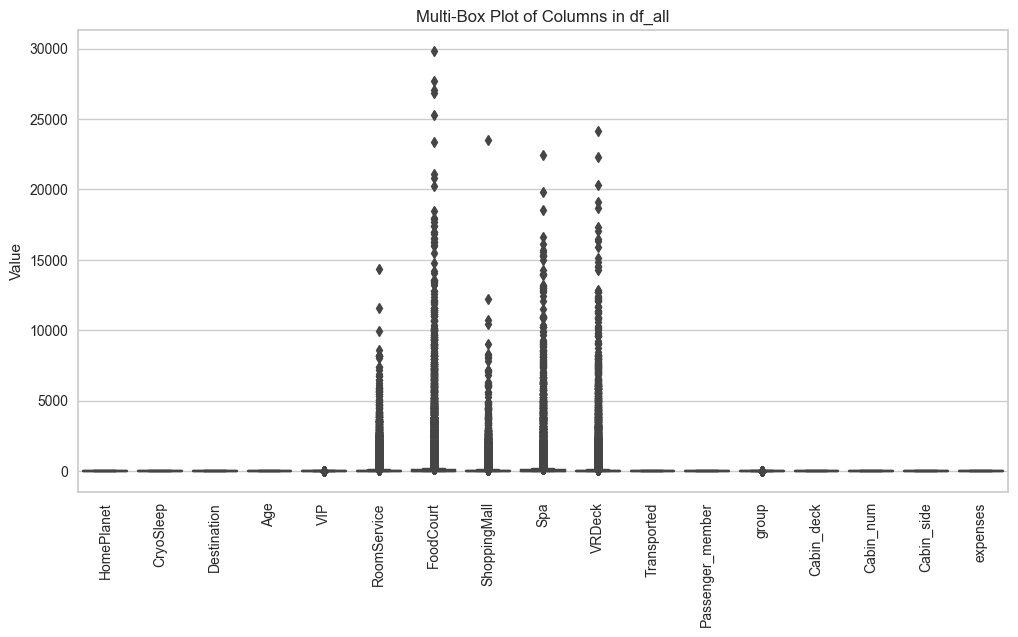

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_all)
plt.title('Multi-Box Plot of Columns in df_all')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()


In [36]:

# ho = df_all.copy()
# ho['group'] = ho['group'].apply(lambda x: 1 if x>=1 else x)
# for name in df_all.columns:
#     sns.countplot(data=df_all, x=name,hue='group' )
#     plt.show()

In [37]:
df_all['group'] = df_all['group'].apply(lambda x: 1 if x>=1 else x)
df_all = df_all.sort_index()
df_all = df_all[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Passenger_member', 'group','Cabin_deck', 'Cabin_num', 'Cabin_side', 'expenses','Transported']]

<Axes: xlabel='Passenger_member', ylabel='count'>

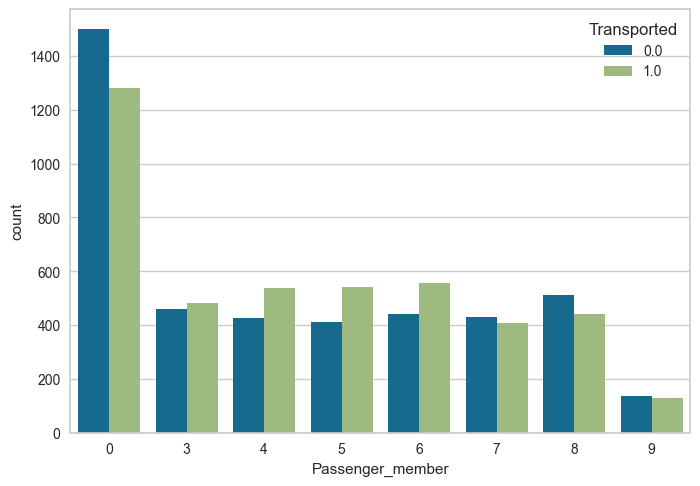

In [38]:
df_all = df_all.copy()
df_all['Passenger_member']  = df_all['Passenger_member'].apply(lambda x: 0 if x<=2 else x)
sns.countplot(data= df_all, x='Passenger_member' , hue= 'Transported')

<Axes: >

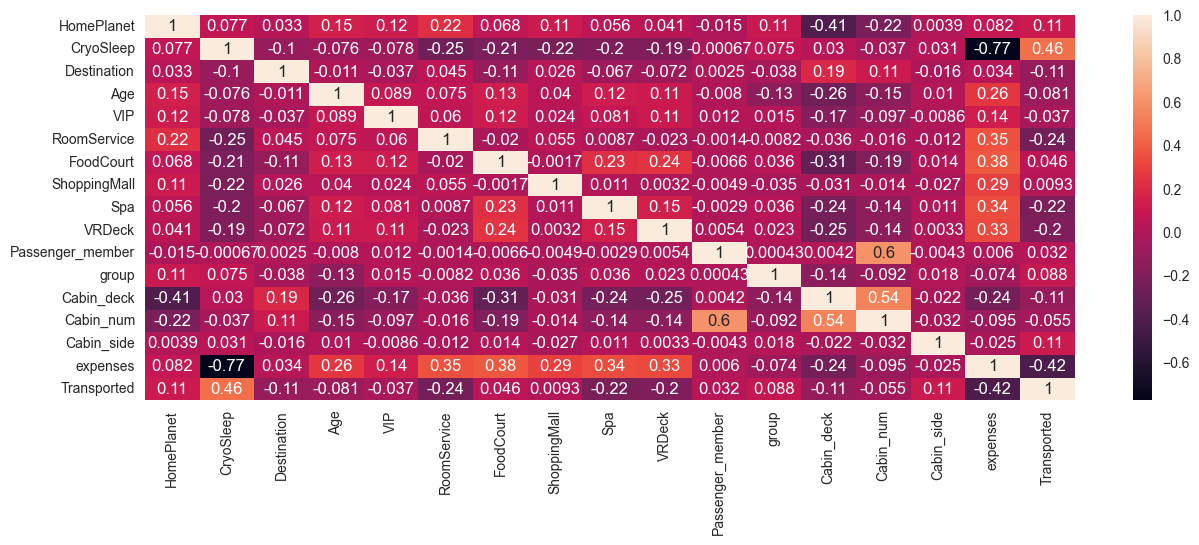

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(df_all.corr(),annot=True)

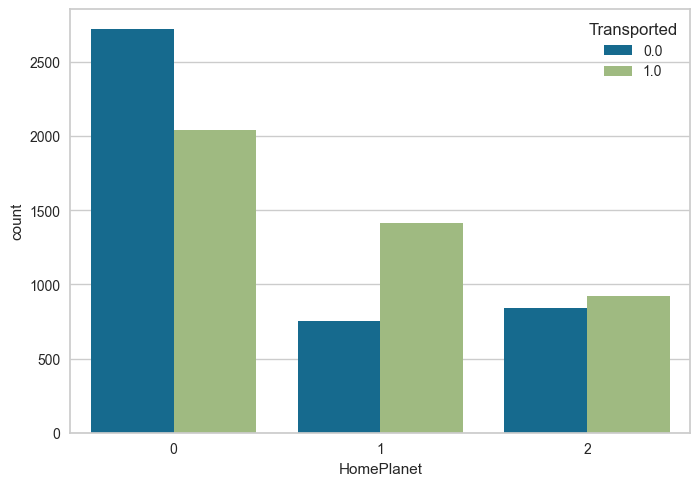

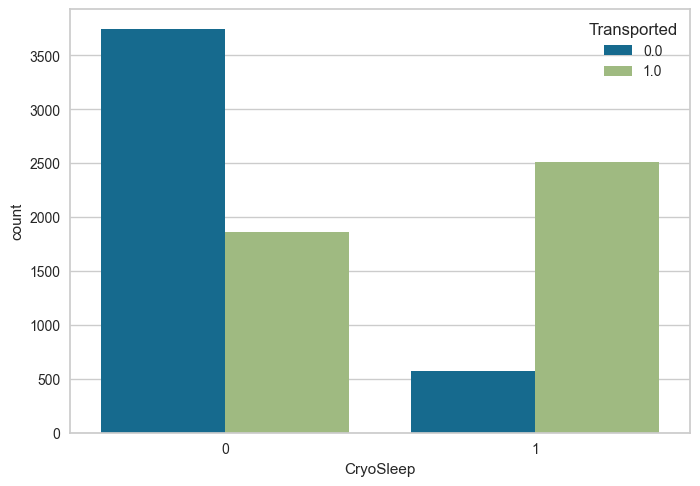

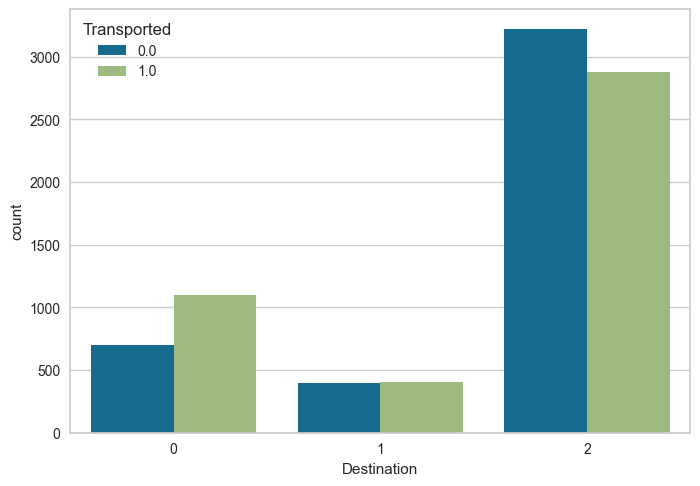

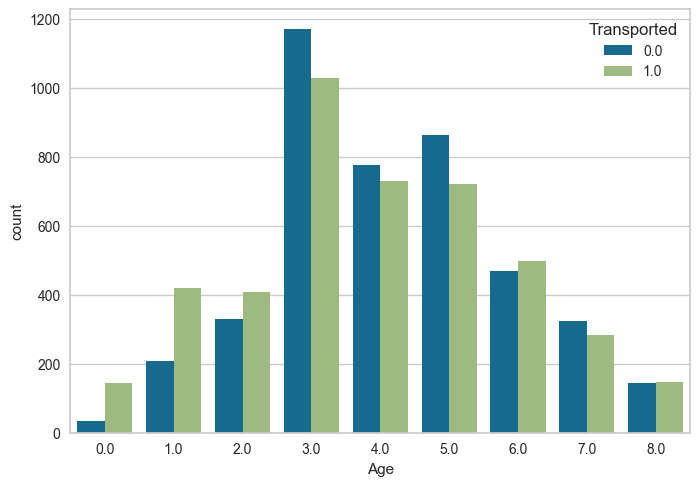

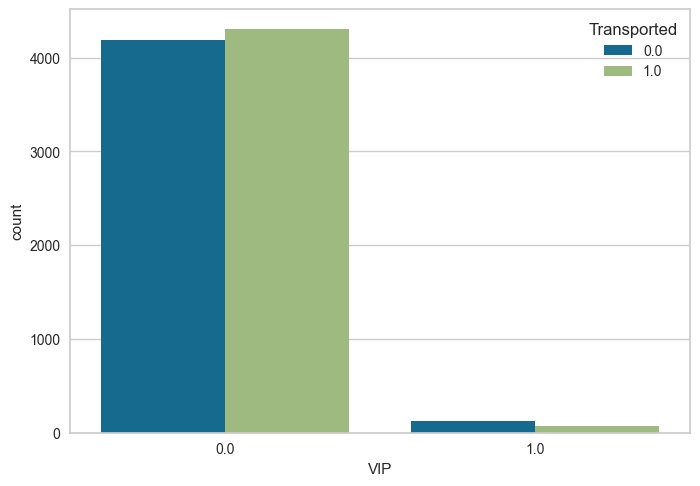

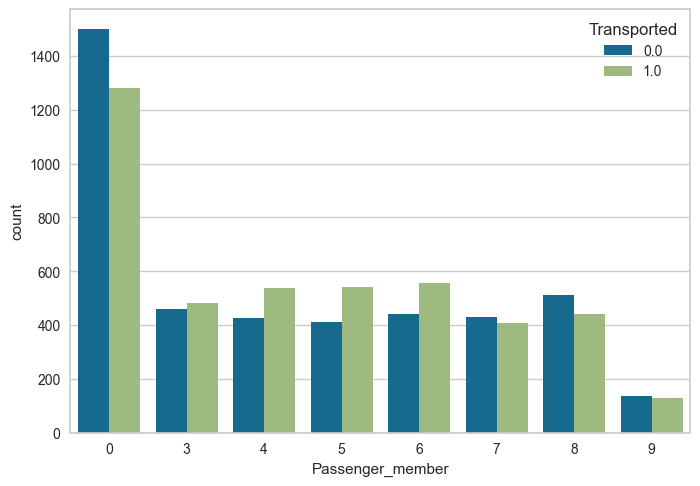

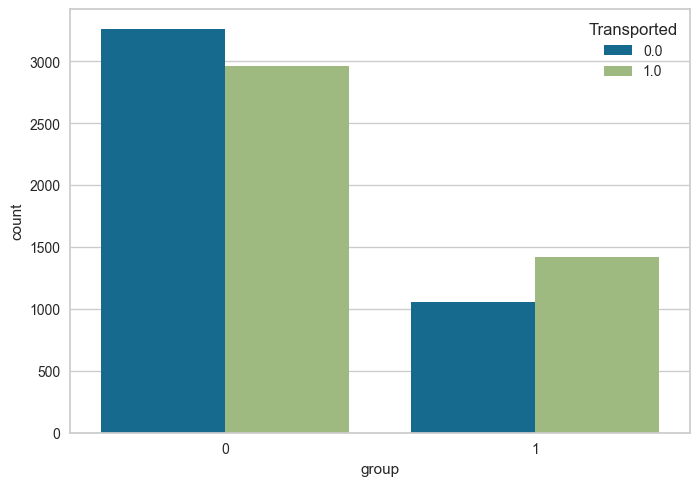

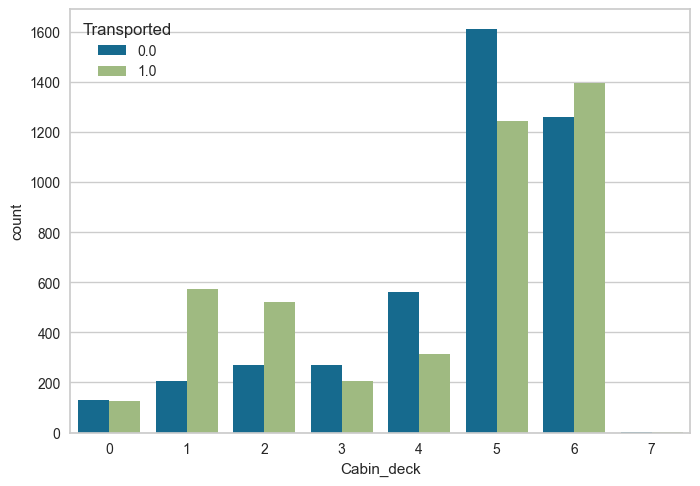

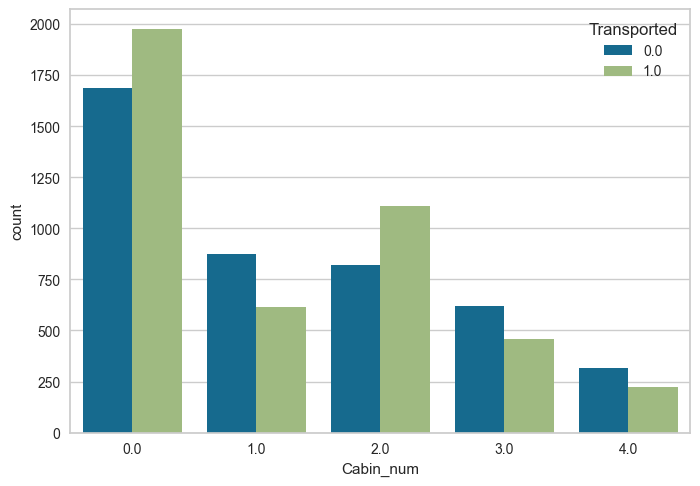

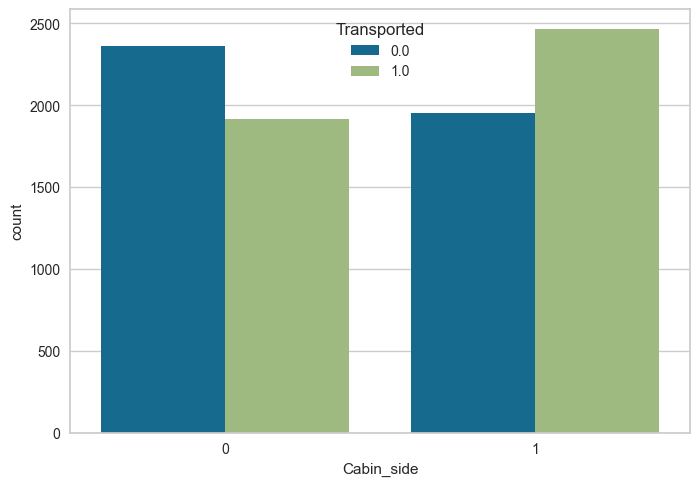

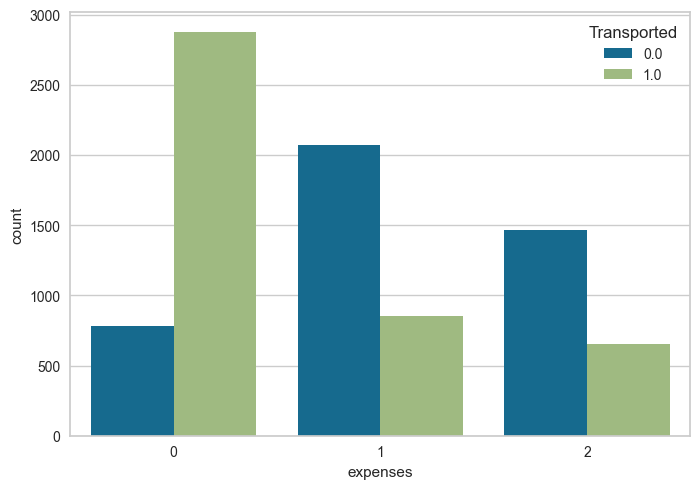

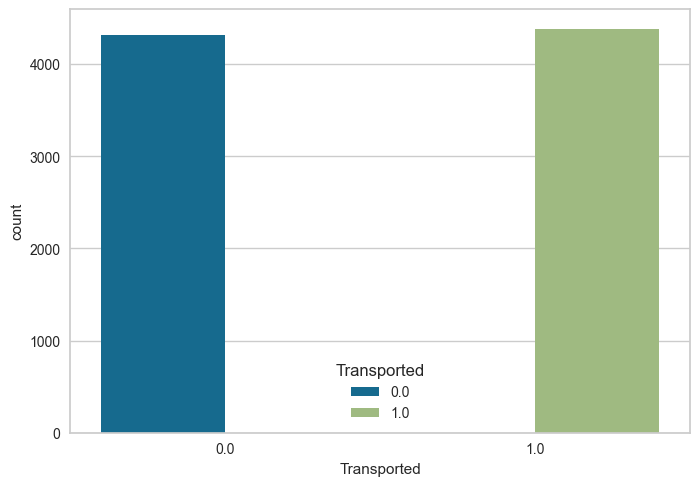

In [44]:
names = 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'Passenger_member','group', 'Cabin_deck', 'Cabin_num', 'Cabin_side', 'expenses','Transported'

for name in names:
    sns.countplot(data= df_all, x= name , hue= 'Transported')
    plt.show()
    

In [50]:
df_all.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Passenger_member',
       'group', 'Cabin_deck', 'Cabin_num', 'Cabin_side', 'expenses',
       'Transported'],
      dtype='object')

In [132]:
label_encoding(df_all, 'Passenger_member')

### 원핫 인코딩을 해줘야하는 columns은

#### HomePlanet, CryoSleep, Destination, VIP, group, Cabin_deck, Cabin_side, 

In [135]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck']
cat_cols = ['CryoSleep','Cabin_deck','Cabin_side','VIP','HomePlanet','Destination',"group"]
label_cols = ['Passenger_member', 'Cabin_num','Age' ]
transported=['Transported']

In [136]:
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)
df_all_cat = pd.DataFrame(ohe.fit_transform(df_all[cat_cols]),columns= ohe.get_feature_names_out())

## model

In [138]:
df_train, df_test = df_all.iloc[:train.shape[0],:],df_all.iloc[train.shape[0]:,:].drop(columns='Transported')
df_test = df_test.astype(int)
df_train = df_train.astype(int)

In [139]:
x_train,y_train = df_train.drop('Transported',axis=1) , df_train['Transported']

In [140]:
s = setup(data= df_train , 
          session_id = 7010,
          target= 'Transported',
          train_size= 0.9,
          fold_strategy='stratifiedkfold',
          fold=5,
          fold_shuffle=True, 
        #   silent= True ,
        #   ignore_low_variance= True, 
        #   remove_multicllinearity=True,
          use_gpu=True,
          normalize = True, 
          normalize_method='robust'
          )


,Description,Value
0,Session id,7010
1,Target,Transported
2,Target type,Binary
3,Original data shape,"(8693, 17)"
4,Transformed data shape,"(8693, 17)"
5,Transformed train set shape,"(7823, 17)"
6,Transformed test set shape,"(870, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [143]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8076,0.9001,0.8142,0.8061,0.8100,0.6152,0.6154,0.2480
catboost,CatBoost Classifier,0.8076,0.9022,0.8236,0.8006,0.8118,0.6151,0.6156,0.1800
xgboost,Extreme Gradient Boosting,0.8016,0.8945,0.7970,0.8069,0.8019,0.6032,0.6034,0.2320
gbc,Gradient Boosting Classifier,0.8012,0.8929,0.8381,0.7827,0.8094,0.6022,0.6038,0.2140
rf,Random Forest Classifier,0.7961,0.8774,0.7619,0.8210,0.7902,0.5924,0.5942,0.3240
et,Extra Trees Classifier,0.7938,0.8566,0.7459,0.8279,0.7847,0.5879,0.5909,0.3340
lr,Logistic Regression,0.7891,0.8724,0.8195,0.7748,0.7965,0.5780,0.5790,0.1960
ada,Ada Boost Classifier,0.7859,0.8759,0.8406,0.7599,0.7982,0.5714,0.5748,0.2340
knn,K Neighbors Classifier,0.7773,0.8500,0.7698,0.7843,0.7769,0.5547,0.5549,0.2700
lda,Linear Discriminant Analysis,0.7684,0.8544,0.7269,0.7955,0.7596,0.5370,0.5391,0.1860


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [155]:
catboost_best = create_model('catboost', 
                             nan_mode='Min',
                             eval_metric='Logloss',
                             iterations=1000,
                             sampling_frequency='PerTree',
                             leaf_estimation_method='Newton',
                             penalties_coefficient=1,
                             boosting_type='Plain',
                             model_shrink_mode='Constant',
                             feature_border_type='GreedyLogSum',
                             l2_leaf_reg=3,
                             random_strength=1,
                             rsm=1,
                             boost_from_average=False,
                             model_size_reg=0.5,
                             subsample=0.800000011920929,
                             use_best_model=False,
                             class_names=[0, 1],
                             depth=6,
                             posterior_sampling=False,
                             border_count=254,
                             classes_count=0,
                             auto_class_weights='None',
                             sparse_features_conflict_fraction=0,
                             leaf_estimation_backtracking='AnyImprovement',
                             best_model_min_trees=1,
                             model_shrink_rate=0,
                             min_data_in_leaf=1,
                             loss_function='Logloss',
                             learning_rate=0.02582800015807152,
                             score_function='Cosine',
                             task_type='CPU',
                             leaf_estimation_iterations=10,
                             bootstrap_type='MVS',
                             max_leaves=64)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8096,0.9043,0.8185,0.8062,0.8123,0.6191,0.6192
1,0.8160,0.9030,0.8236,0.8133,0.8184,0.6319,0.6319
2,0.8058,0.9018,0.8147,0.8025,0.8086,0.6114,0.6115
3,0.8165,0.9071,0.7995,0.8300,0.8145,0.6331,0.6335
4,0.8088,0.8995,0.8185,0.8052,0.8118,0.6176,0.6177
Mean,0.8113,0.9031,0.8150,0.8115,0.8131,0.6226,0.6228
Std,0.0042,0.0025,0.0082,0.0099,0.0033,0.0085,0.0085


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [156]:
from pycaret.classification import create_model

lightgbm = create_model('lightgbm')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8147,0.9024,0.8211,0.8128,0.8169,0.6293,0.6294
1,0.8096,0.8998,0.8185,0.8062,0.8123,0.6191,0.6192
2,0.8051,0.8989,0.8198,0.7985,0.8090,0.6101,0.6104
3,0.8088,0.9037,0.7919,0.8221,0.8067,0.6177,0.6182
4,0.7999,0.8958,0.8198,0.7907,0.8050,0.5996,0.6000
Mean,0.8076,0.9001,0.8142,0.8061,0.8100,0.6152,0.6154
Std,0.0049,0.0028,0.0112,0.0109,0.0042,0.0099,0.0098


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [223]:
df_pred = predict_model(catboost_best, df_test)
y_pred = df_pred[['prediction_label']].reset_index(drop=True)

In [224]:
submission['Transported'] = y_pred['prediction_label']
submission['Transported'] = submission['Transported'].astype(bool)
submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
5,0027_01,False
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


In [225]:
submission.to_csv('submission1.csv',index=False)